# 1.-Intalacion de librerias

In [ ]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [11]:
import tensorflow as tf
import os

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# 2.-LIMPIAR IMAGENES DE RUTA DESCONOCIDA

In [19]:
import cv2
import imghdr

In [22]:
data_dir = 'dataset-resized' 

In [23]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [24]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list dataset-resized\cardboard\cardboard1.xml
Image not in ext list dataset-resized\cardboard\cardboard10.xml
Image not in ext list dataset-resized\cardboard\cardboard11.xml
Image not in ext list dataset-resized\cardboard\cardboard12.xml
Image not in ext list dataset-resized\cardboard\cardboard13.xml
Image not in ext list dataset-resized\cardboard\cardboard14.xml
Image not in ext list dataset-resized\cardboard\cardboard15.xml
Image not in ext list dataset-resized\cardboard\cardboard16.xml
Image not in ext list dataset-resized\cardboard\cardboard17.xml
Image not in ext list dataset-resized\cardboard\cardboard18.xml
Image not in ext list dataset-resized\cardboard\cardboard19.xml
Image not in ext list dataset-resized\cardboard\cardboard2.xml
Image not in ext list dataset-resized\cardboard\cardboard20.xml
Image not in ext list dataset-resized\cardboard\cardboard3.xml
Image not in ext list dataset-resized\cardboard\cardboard4.xml
Image not in ext list dataset-resized\cardbo

# 3.-CARGAR DATOS

In [36]:
import numpy as np
from matplotlib import pyplot as plt

In [37]:
data = tf.keras.utils.image_dataset_from_directory('dataset-resized')

Found 2527 files belonging to 6 classes.


In [38]:
data_iterator = data.as_numpy_iterator()

In [39]:
batch = data_iterator.next()

In [40]:
len(batch)

2

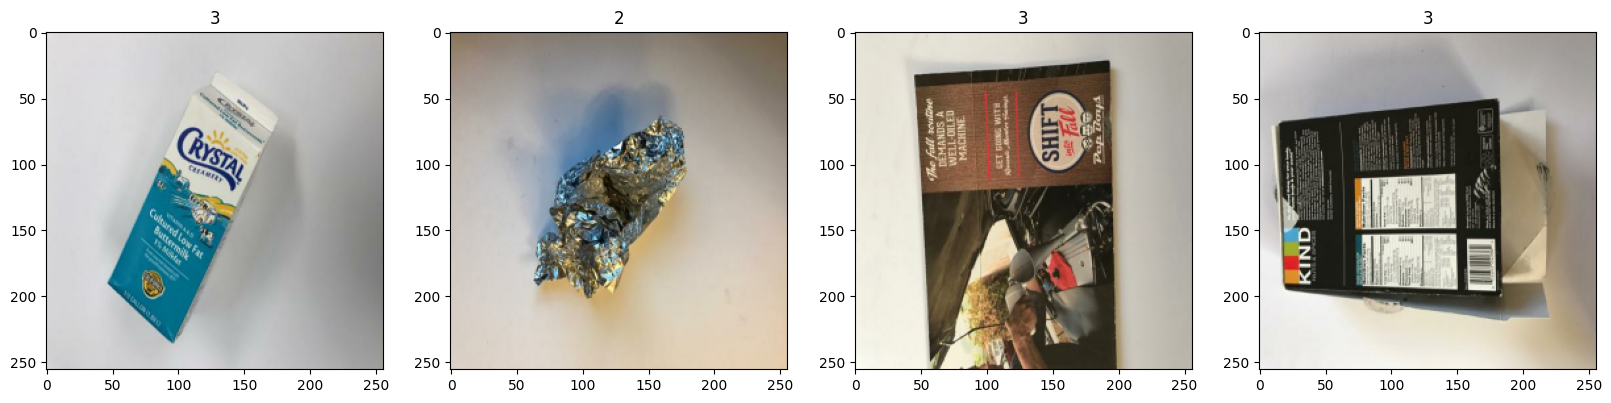

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4.- SCALAR DATOS